# Dusty Galaxies as Seen by SPHEREx
The goal of this project is to prepare for the SPHEREx observations by characterizing the population of galaxies that will be observed given its sensitivity and survey limits, and to leverage SPHEREx’s data products by generating models against which the observational data can be tested. The project will be carried out in two steps: first obtaining a characterization of the parameter space of observations and second using those parameters to simulate spectra that are to be observed by SPHEREx.

# Part 1
In part 1 of this project, we seek to catagorize objects previously detected by the AKARI telescope into a new catalog that can be used by SphereX. We begin by importing the necessary packages.

In [13]:
# Import packages
import os, sys
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
import random
from astropy.table import Table, vstack, hstack
import astropy.table as table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
import astropy.cosmology as cosmology
from scipy import ndimage
from scipy.stats import gaussian_kde
from tqdm import tqdm
import colorcet as cc
from fast_histogram import histogram2d

## NEPD SED
Next, we plot the SEDs given the wavelengths of the filters and bands from the NEPD catalog. We then filter out the objects outside of SphereX's sensitivities, and add the remaining objects to our catalog. 

This catalog is later replaced by the HSC catalog. This code will be deleted when necessary.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 44.27it/s]


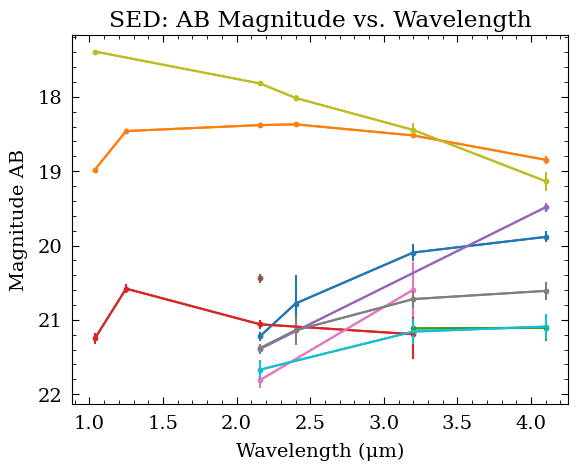

In [14]:
# A 2-D array of the wavelengths of the 9 different bands
band_wavelengths = [['N2', 2.4, '1.9-2.8'], ['N3', 3.2, '2.7-3.8'], ['N4', 4.1, '3.6-5.3'], 
              ['S7', 7.0, '5.9-8.4'], ['S9W', 9.0, '6.7-11.6'], ['S11', 11.0, '8.5-13.1'], 
              ['L15', 15.0, '12.6-19.4'], ['L18W', 18.0, '13.9-25.6'], ['L24', 24.0, '20.3-36.5']]

# A 2-D array of the wavelengths of the 13 different filters
filter_wavelengths = [['u*', 0.382329], ['g*', 0.487737], ['r*', 0.623062], 
                      ['i*', 0.761766], ['z*', 0.882798], ['Y', 1.036794], 
                      ['J', 1.249102], ['Ks', 2.159044], ['B', 0.445832], 
                      ['V', 0.547783], ['r+', 0.628871], ['i+', 0.768388], 
                      ['z+', 0.903688], ['NB711', 0.711988]]

# A 2-D array where rows represent each object and columns represent the magnitudes from 
# the 9 bands (flux converted to AB magnitude) and the 13 different filters
mag = []

# A 2-D array where rows represent each object and columns represent the errors in magnitude 
# from the 9 bands (flux converted to AB magnitude) and the 13 different filters
mag_err = []

# A 1-D array of RA for each object. Used to match to HSC later.
nepd_ra = []

# A 1-D array of DEC for each object. Used to match to HSC later.
nepd_dec = []

# Convert error in flux to error in magnitude 
def flux_mag_err(flux, flux_err):
    if(flux_err < 0):
        return 0
    return (2.5 / np.log(10) * flux_err / flux)
    
# Fill in data for y_axis (flux and mag) from the catalog
# 27770 objects in AKARI_NEPD_V2
with open('AKARI_NEPD_V2.txt') as f:
    data = f.readlines()
    for i in range(len(data)):
        info = data[i].split()
        band_mag = []
        filt_mag = []
        band_err = []
        filt_err = []
        for j in range(9):
            # Check for a flag of 0
            if(float(info[53 + j * 3]) != -1):
                flux = float(info[51 + j * 3])
                flux_err = float(info[52 + j * 3])
                # Convert flux in Jy to magnitude
                ab_mag = -2.5 * np.log10(flux) + 8.9
                band_mag.append(ab_mag)
                f_err = flux_mag_err(flux, flux_err)
                band_err.append(f_err)
            else:
                band_mag.append(-1)
                band_err.append(-1)
        for k in range(14):
            # Check for a flag of 0
            if(float(info[11 + k * 3]) != -1):
                filt_mag.append(float(info[9 + k * 3]))
                filt_err.append(float(info[10 + k * 3]))
            else:
                filt_mag.append(-1)
                filt_err.append(-1)
        mag.append(filt_mag + band_mag)
        mag_err.append(filt_err + band_err)
        nepd_ra.append(float(info[2]))
        nepd_dec.append(float(info[3]))

# Fill x_axis with wavelengths from above
x_axis = []
for i_filt in range(len(filter_wavelengths)):
    x_axis.append(float(filter_wavelengths[i_filt][1]))
for i_band in range(len(band_wavelengths)):
    x_axis.append(float(band_wavelengths[i_band][1]))

# Array of indices of the objects we want in our catalog
ind = []

# Plot SED
for j in tqdm(range(10)):
    z = list(zip(x_axis, mag[j], mag_err[j]))
    ax = sorted(z, key = lambda x: x[0])
    x = []
    y = []
    y_err = []
    for k in range(len(ax)):
        # Filter for SphereX sensitivities
        if(ax[k][0] >= 0.7 and ax[k][0] <= 5.5 and ax[k][1] >= 10 and ax[k][1] <= 22):
        # No filter
        # if(ax[k][1] > 0):
            x.append(ax[k][0])
            y.append(ax[k][1])
            y_err.append(ax[k][2])
            ind.append(j)
    line = plt.plot(x, y)
    plt.scatter(x, y, s = 10)
    plt.errorbar(x, y, yerr = y_err, color = line[0].get_color())

plt.xlabel('Wavelength (μm)')
plt.ylabel('Magnitude AB')
plt.gca().invert_yaxis()
plt.title('SED: AB Magnitude vs. Wavelength')
plt.show()

# Catalog of data from the relevant indices
ind = [*set(ind)]
catalog = []
for i in ind:
    info = data[i].split()
    cat = []
    cat.append(info[0])
    cat.append(info[2])
    cat.append(info[3])
    cat.append(mag[i])
    catalog.append(cat)

## HSC SED
Using the SUBARU/HSC catalog, we first define the arrays with the data that we will be using.

In [15]:
# Read in the contents from HSC catalog and parse into arrays by headers
# 70959 objects in AKARI_HSC_Oi21
hsc = Table.read('AKARI_HSC_Oi21.txt', format = 'ascii', header_start = 0)
hsc_akari_id = hsc['AKARI_ID']
hsc_id = hsc['HSC_ID']
hsc_ra = hsc['HSC_RA']
hsc_dec = hsc['HSC_DEC']
hsc_photoz = hsc['photoZ']
hsc_q = hsc['cls_quiescent']
hsc_sf = hsc['cls_starforming']
hsc_t1 = hsc['cls_type1AGN']
hsc_t2 = hsc['cls_type2AGN']
hsc_specz = hsc['specZ']
hsc_lum_ir = hsc['LUM_totIR']
hsc_len = len(hsc_akari_id)

We then match the NEPD and HSC objects for a sanity check. All of the NEPD objects were matched to HSC objects, so from here on we use only the HSC catalog. This code is commented out to save space, and it will be deleted when necessary.

In [16]:
# Match NEPD and HSC for sanity check
c = SkyCoord(ra = nepd_ra * u.degree, dec = nepd_dec * u.degree)
catalog = SkyCoord(ra = hsc_ra * u.degree, dec = hsc_dec * u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
for i in range(10):
    print("NEPD ID: " + str(data[i].split()[0]) + " -----> HSC AKARI ID: " + str(hsc_akari_id[idx[i]]))

NEPD ID: 61000001 -----> HSC AKARI ID: 27010
NEPD ID: 61000002 -----> HSC AKARI ID: 38263
NEPD ID: 61000003 -----> HSC AKARI ID: 35842
NEPD ID: 61000004 -----> HSC AKARI ID: 38263
NEPD ID: 61000005 -----> HSC AKARI ID: 27783
NEPD ID: 61000006 -----> HSC AKARI ID: 15841
NEPD ID: 61000007 -----> HSC AKARI ID: 15527
NEPD ID: 61000008 -----> HSC AKARI ID: 25563
NEPD ID: 61000009 -----> HSC AKARI ID: 16613
NEPD ID: 61000010 -----> HSC AKARI ID: 13814


We now create the SEDs of AB Magntidue vs. Wavelength using the HSC catalog, filtering out the objects outside of SphereX's sensitivities as well as any stars. We then plot the first few galaxies within SphereX's sensitivities into an SED with error bars.

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.67it/s]


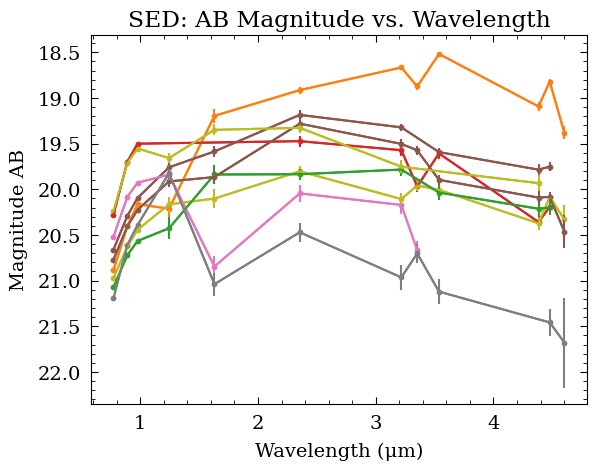

In [17]:
# Create SED using HSC catalog instead of NEPD catalog
# A 1-D array of the wavelengths corresponding to the 31 filters in HSC
hsc_wavelengths = [0.367612, 0.479821, 0.621844, 
                   0.772701, 0.890850, 0.977507,
                   1.024151, 1.251872, 2.143400, 
                   1.244490, 1.629968, 2.355041, 
                   3.217903, 4.383010, 7.176359, 
                   8.850856, 10.637881, 15.802996,
                   18.921777, 23.120108, 3.352600, 
                   4.602800, 11.560800, 22.088300, 
                   3.537841, 4.478049, 100.01,
                   162, 248, 348, 500]

# A 1-D array of the names of the 31 filters in HSC
hsc_filter_names = ['mega_um', 'hscGCm', 'hscRCm', 
                    'hscICm', 'hscZCm', 'hscYCm', 
                    'wirYm', 'wirJm', 'wirKsm', 
                    'flmnJm', 'flmnHm', 'N2m', 
                    'N3m', 'N4m', 'S7m', 
                    'S9m', 'S11m', 'L15m', 
                    'L18m', 'L24m', 'wiseW1m', 
                    'wiseW2m', 'wiseW3m', 'wiseW4m', 
                    'spt36m', 'spt45m', 'her100m',
                    'her160m', 'her250m', 'her350m', 'her500m']

# A 1-D array of the names of the 31 filter errors in HSC
hsc_filter_error_names = ['mega_ume', 'hscGCme', 'hscRCme', 
                          'hscICme', 'hscZCme', 'hscYCme', 
                          'wirYme', 'wirJme', 'wirKsme', 
                          'flmnJme', 'flmnHme', 'N2me', 
                          'N3me', 'N4me', 'S7me', 
                          'S9me', 'S11me', 'L15me', 
                          'L18me', 'L24me', 'wiseW1me', 
                          'wiseW2me', 'wiseW3me', 'wiseW4me', 
                          'spt36me', 'spt45me', 'her100me', 
                          'her160me', 'her250me', 'her350me', 'her500me']

# Array of indices of the objects we want in our catalog
ind = []

# A 2-D array where rows represent each object and columns represent the magnitudes
hsc_mag = []

# A 2-D array where rows represent each object and columns represent the errors in magnitude
hsc_mag_err = []

# Fill hsc_mag and hsc_mag_err
for i in range(hsc_len):
    mag_temp = []
    mag_err_temp = []
    for j in range(len(hsc_filter_names)):
        mag_temp.append(hsc[hsc_filter_names[j]][i])
        mag_err_temp.append(hsc[hsc_filter_error_names[j]][i])
    hsc_mag.append(mag_temp)
    hsc_mag_err.append(mag_err_temp)

# Plot SED for first few objects
def hsc_plot(n):
    for j in tqdm(range(n)):
        z = list(zip(hsc_wavelengths, hsc_mag[j], hsc_mag_err[j]))
        ax = sorted(z, key = lambda x: x[0])
        x = []
        y = []
        y_err = []
        # Only count galaxies
        if(hsc['cls_star'][j] == 0):
            for k in range(len(ax)):
                # Filter for SphereX sensitivities
                if(ax[k][0] >= 0.7 and ax[k][0] <= 5.5 and ax[k][1] >= 10 and ax[k][1] <= 22):
                # No filter
                # if(ax[k][1] > 0):
                    if(ax[k][2] < 0):
                        y_err.append(0)
                    else:
                        y_err.append(ax[k][2])
                    x.append(ax[k][0])
                    y.append(ax[k][1])
        line = plt.plot(x, y)
        plt.scatter(x, y, s = 10)
        plt.errorbar(x, y, yerr = y_err, color = line[0].get_color())
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Magnitude AB')
    plt.gca().invert_yaxis()
    plt.title('SED: AB Magnitude vs. Wavelength')
    plt.show()
hsc_plot(20)

Here we create a new catalog from all of the remaining galaxes from HSC that are within the sensitivities of SphereX.

In [18]:
# Fill ind for our catalog from all valid objects in HSC catalog
for l in range(hsc_len):
    z = list(zip(hsc_wavelengths, hsc_mag[l], hsc_mag_err[l]))
    ax = sorted(z, key = lambda x: x[0])
    # Only count galaxies
    if(hsc['cls_star'][l] == 0):
        for m in range(len(ax)):
            # Filter for SphereX sensitivities
            if(ax[m][0] >= 0.7 and ax[m][0] <= 5.5 and ax[m][1] >= 10 and ax[m][1] <= 22):
                ind.append(l)

# Catalog of data from the relevant indices
# 52290 objects when counting only galaxies
ind = [*set(ind)]

# Filter names and errors with wavelengths within SPHEREx sensitivities
sx_filt = ['hscICm', 'hscICme', 'hscZCm', 
           'hscZCme', 'hscYCm', 'hscYCme', 
           'wirYm', 'wirYme', 'wirJm', 
           'wirJme', 'wirKsm', 'wirKsme', 
           'flmnJm', 'flmnJme', 'flmnHm', 
           'flmnHme', 'N2m', 'N2me', 
           'N3m', 'N3me', 'N4m', 
           'N4me', 'wiseW1m', 'wiseW1me', 
           'wiseW2m', 'wiseW2me', 'spt36m', 
           'spt36me', 'spt45m', 'spt45me',]
sx_wavelengths = [0.772701, 0.890850, 0.977507,
                   1.024151, 1.251872, 2.143400, 
                   1.244490, 1.629968, 2.355041, 
                   3.217903, 4.383010, 3.352600, 
                   4.602800, 3.537841, 4.478049]

# Set the header for our catalog
pre = ['AKARI_ID', 'HSC_ID', 'HSC_RA', 'HSC_DEC']
post = ['photoZ', 'cls_quiescent', 'cls_starforming', 
        'cls_type1AGN', 'cls_type2AGN', 'specZ', 'LUM_totIR']
c = [pre, sx_filt, post]
ca = []
for l in c:
    ca += l
catalog = [ca]

# Fill the data for the catalog
for i in ind:
    cata = []
    cata.append(hsc_akari_id[i])
    cata.append(hsc_id[i])
    cata.append(hsc_ra[i])
    cata.append(hsc_dec[i])
    for j in range(len(sx_filt)):
        cata.append(hsc[sx_filt[j]][i])
    cata.append(hsc_photoz[i])
    cata.append(hsc_q[i])
    cata.append(hsc_sf[i])
    cata.append(hsc_t1[i])
    cata.append(hsc_t2[i])
    cata.append(hsc_specz[i])
    cata.append(hsc_lum_ir[i])
    catalog.append(cata)
    
# Write the contents of our catalog onto a txt file
f = open('SURF_2023_CATALOG.txt', 'w')
for c in catalog:
    line = ', '.join(str(s) for s in c)
    f.write(line + '\n')
f.close()

## SURF Catalog
Now that our catalog is defined, we can parse the arrays with respect to our catalog just like we did with HSC.

In [19]:
# Parse the arrays from our new catalog
cat = Table.read('SURF_2023_CATALOG.txt', format = 'ascii', header_start = 0)
cat_akari_id = cat['AKARI_ID']
cat_id = cat['HSC_ID']
cat_ra = cat['HSC_RA']
cat_dec = cat['HSC_DEC']
cat_photoz = cat['photoZ']
cat_q = cat['cls_quiescent']
cat_sf = cat['cls_starforming']
cat_t1 = cat['cls_type1AGN']
cat_t2 = cat['cls_type2AGN']
cat_specz = cat['specZ']
cat_lum_ir = cat['LUM_totIR']
cat_len = len(cat_akari_id)

Let us now plot the spectral vs. photometric redshifts of each object.

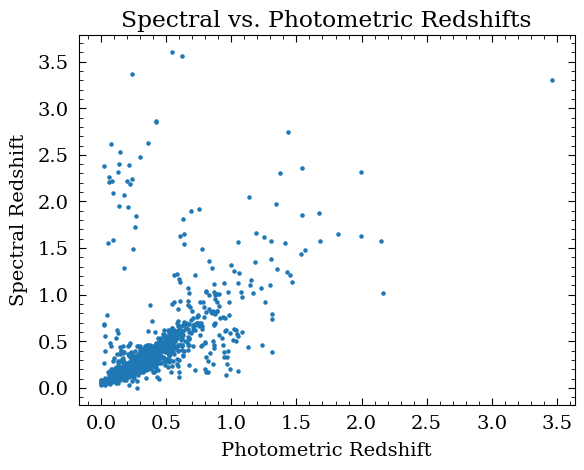

In [20]:
# Plot spectral vs. photometric redshifts
def z_plot():
    z = list(zip(cat_photoz, cat_specz))
    ax = sorted(z, key = lambda x: x[0])
    x = []
    y = []
    for k in range(len(ax)):
        # Filter out the unknown values
        if(ax[k][0] != -99 and ax[k][1] != -99):
            x.append(ax[k][0])
            y.append(ax[k][1])
    plt.scatter(x, y, s = 5)
    plt.xlabel('Photometric Redshift')
    plt.ylabel('Spectral Redshift')
    plt.title('Spectral vs. Photometric Redshifts')
    plt.show()
z_plot()

Now we plot the star formation rate vs. photometric redshift of the galaxies.

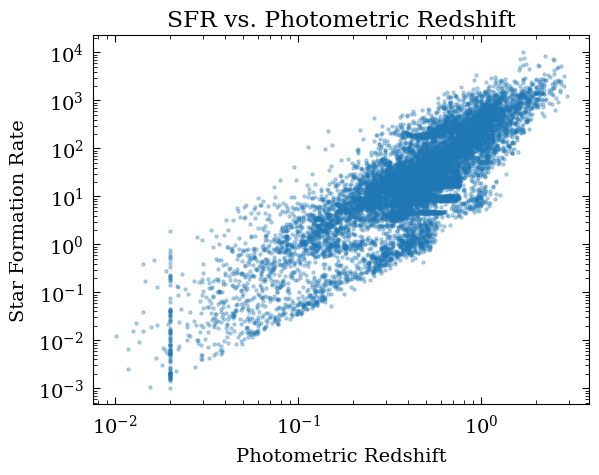

In [29]:
# Convert total infrared luminosity to star formation rate
def LIR_to_SFR(lir_log):
    lir_lin = 10**lir_log
    lir_ergs = 3.828e33 * lir_lin
    sfr = 4.5e-44 * lir_ergs
    return sfr

sfr = []
def sfr_z_plot():
    for i in cat_lum_ir:
        if(i < 0):
            sfr.append(-1.0)
        else:
            sfr.append(LIR_to_SFR(i))
    z = list(zip(cat_photoz, sfr))
    ax = sorted(z, key = lambda x: x[0])
    x = []
    y = []
    for k in range(len(ax)):
        # Filter out the unknown values
        if(ax[k][0] != -99 and ax[k][1] >= 1e-10):
            x.append(ax[k][0])
            y.append(ax[k][1])
    plt.scatter(x, y, s = 5, alpha = 0.3)
    plt.xlabel('Photometric Redshift')
    plt.ylabel('Star Formation Rate')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('SFR vs. Photometric Redshift')
    plt.show()
sfr_z_plot()

We can now compare the types of galaxies to their photometric redshifts.

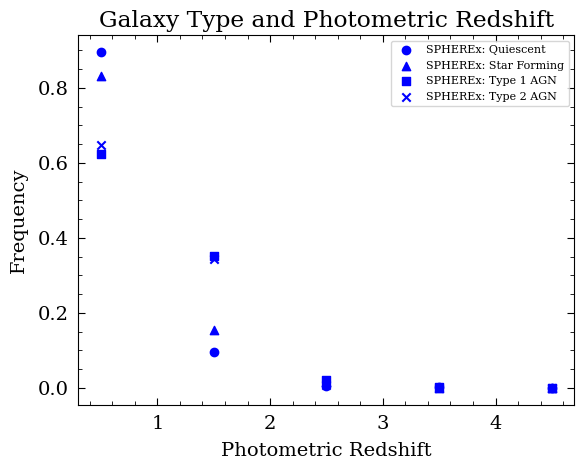

In [22]:
# Function that takes in galaxy type ('q', 'sf', 't1', 't2')
# and returns list with 5 items. 
# Each item is the percent of galaxies of that given type that have a 
# redshift of 0-1, 1-2, 2-3, 3-4, and 4-5 respectively
def galaxy_rs(type, gal, len, photoz):
    if type not in ['q', 'sf', 't1', 't2']:
        print('Invalid galaxy type')
        return []
    tot = 0
    num = [0, 0, 0, 0, 0]
    for i in range(len):
        if(gal[i] == 1):
            tot += 1
            ind = math.floor(photoz[i])
            num[ind] += 1
    freq = []
    for j in num:
        freq.append(j / tot)
    return freq
    
galaxy_types = ['q', 'sf', 't1', 't2']
redshifts = [0.5, 1.5, 2.5, 3.5, 4.5]
def gal_plot(n):
    for j in range(n):
        for i in galaxy_types:
            if(i == 'q'):
                if(j == 0):
                    gal = cat_q
                else:
                    gal = hsc_q
                l = 'Quiescent'
                m = 'o'
            elif(i == 'sf'):
                if(j == 0):
                    gal = cat_sf
                else:
                    gal = hsc_sf
                l = 'Star Forming'
                m = '^'
            elif(i == 't1'):
                if(j == 0):
                    gal = cat_t1
                else:
                    gal = hsc_t1
                l = 'Type 1 AGN'
                m = 's'
            elif(i == 't2'):
                if(j == 0):
                    gal = cat_t2
                else:
                    gal = hsc_t2
                l = 'Type 2 AGN'
                m = 'x'
            if(j == 0):       
                plt.scatter(redshifts, galaxy_rs(i, gal, cat_len, cat_photoz), label = 'SPHEREx: ' + l, c = 'blue', marker = m)
            else:
                plt.scatter(redshifts, galaxy_rs(i, gal, hsc_len, hsc_photoz), label = 'HSC: ' + l, c = 'green', marker = m)
    plt.legend(fontsize = 8)
    plt.xlabel('Photometric Redshift')
    plt.ylabel('Frequency')
    plt.title('Galaxy Type and Photometric Redshift')
    plt.show()
gal_plot(1)

We can also count the number of each galaxy type as well as the percentages of each galaxy type from all the galaxies in our catalog.

In [23]:
def gal_types():
    cat_q = cat['cls_quiescent']
    cat_sf = cat['cls_starforming']
    cat_t1 = cat['cls_type1AGN']
    cat_t2 = cat['cls_type2AGN']
    cat_photoz = cat['photoZ']
    cat_q = np.array(cat_q)
    cat_sf = np.array(cat_sf)
    cat_t1 = np.array(cat_t1)
    cat_t2 = np.array(cat_t2)
    cat_photoz = np.array(cat_photoz)
    
    q_points = cat_photoz[cat_q == 1]
    sf_points = cat_photoz[cat_sf == 1]
    t1_points = cat_photoz[cat_t1 == 1]
    t2_points = cat_photoz[cat_t2 == 1]
    
    # Find the number of each galaxy type
    print('Quiescent: ' + str(len(q_points)) + ' = ' + str(len(q_points) / cat_len * 100) + '%')
    print('Star Forming: ' + str(len(sf_points)) + ' = ' + str(len(sf_points) / cat_len * 100) + '%')
    print('Type 1 AGN: ' + str(len(t1_points)) + ' = ' + str(len(t1_points) / cat_len * 100) + '%')
    print('Type 2 AGN: ' + str(len(t2_points)) + ' = ' + str(len(t2_points) / cat_len * 100) + '%')
gal_types()

Quiescent: 4602 = 8.800917957544463%
Star Forming: 41027 = 78.46050870147255%
Type 1 AGN: 2635 = 5.039204436794798%
Type 2 AGN: 4026 = 7.699368904188181%


## Stellar Mass
We now want to gather other physical properties of the galaxies selected in our catalog. One such property is the stellar mass of the galaxies. We begin by finding the stellar masses of our template SEDs.

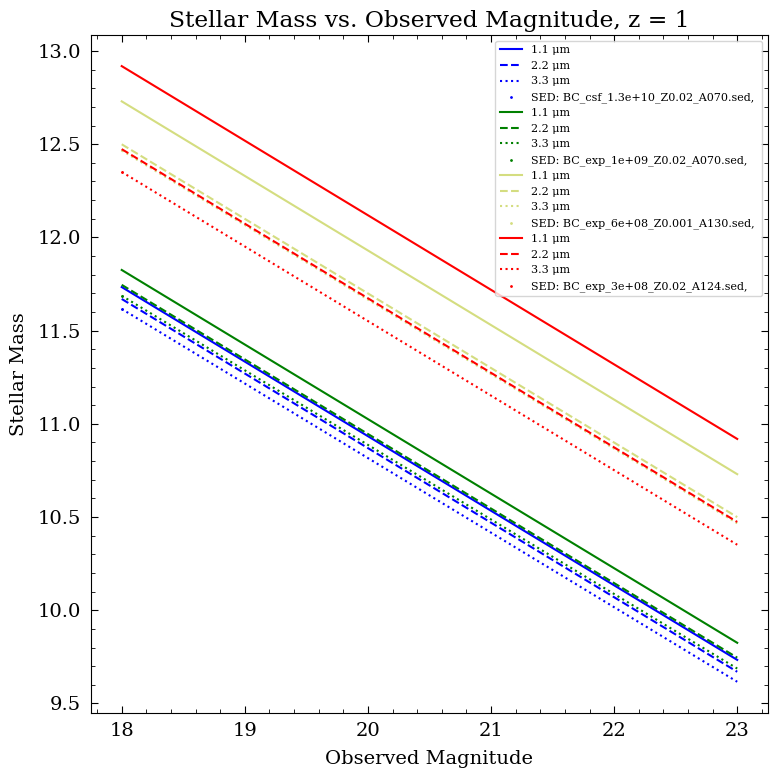

In [25]:
with open('csf_exp_seds.txt') as f:
    data = f.readlines()
csf_exp_seds = []
info = []
for i in range(len(data)):
    if(data[i].lstrip()[:3] == 'BC_'):
        if(i != 0):
            csf_exp_seds.append(info)
        info = []
        header = data[i].split()
        info.append(header[0])
        source = ""
        for j in range(9):
            source = source + header[13 + j] + " "
        source = source[:-1]
        info.append(source)
    else:
        info.append(data[i][:-1])
# print(csf_exp_seds[0][0])
# print(csf_exp_seds[0][1])
# print(csf_exp_seds[0][2])
# print(csf_exp_seds[0][15].split()[0])
# print(csf_exp_seds[0][15].split()[1])
# print(csf_exp_seds[0][len(csf_exp_seds[0]) - 1])


# print(data[21860965])
# print(len(data))
# Last: BC_exp_9e+09_Z0.04_A150.sed

# Plotting stuff
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelpad'] = 7
mpl.rcParams['xtick.major.pad'] = 7
mpl.rcParams['ytick.major.pad'] = 7
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rc('font', family = 'serif')
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1

# Cosmology
cosmo = cosmology.FlatLambdaCDM(H0 = 70, Om0 = 0.3)

def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_SED(sed_name):
    '''
    Read an SED and returns (sed , params)
    
    '''
    
    # CSP SED from SSP: BC SFR: CSF til1.3e+10 yrs
    # SFRindex:               16
    # Z:                      0.02
    # SFR Mass(t):            0.0371372
    # MStars/MSFRMass(t):     0.696841
    # Epoch (yr):             4.82789e+08
    # Light weighted Age Bol: 5.4045e+07
    # Light weighted Age B:   1.17214e+08
    # Light weighted Age V:   1.35019e+08
    # Mass weighted Age:      2.41397e+08
    # Mass to Light Bol:      0.027872
    # Mass to Light B:        0.0608915
    # Mass to Light V:        0.107237
    
    ## Define path (hard coded - need to be changed.)
    # sed_path = "/Users/afaisst/Work/SEDtemplates/BC03/BASIC"
    # sed_path = "/Users/ezhan/Downloads/csf_exp_seds.tar.gz"
    
    ## Load the SED
    flat = [e for r in csf_exp_seds for e in r]
    index = flat.index(sed_name)
    ind = index // len(csf_exp_seds[0])
    lam = []
    L_lam = []
    # Find the first index of lam and L_lam
    start = 0
    for k in range(len(csf_exp_seds[ind])):
        if(csf_exp_seds[ind][k].split()[0].replace(".", "").isnumeric()):
            break
        else:
            start = start + 1
    for i in range(start, len(csf_exp_seds[ind])):
        lam.append(float(csf_exp_seds[ind][i].split()[0]))
        L_lam.append(float(csf_exp_seds[ind][i].split()[1]))
    # sed = table.Table([lam, L_lam], names=['lam', 'L_lam'])
    # sed = ascii.read('csf_exp_seds.txt', names = ["lam", "L_lam"]) # lam is in angstroms; luminosity is in [erg/s/A/Msol]

    ## Convert Llam to Lnu in erg/s/Hz/Msol
    L_nu = []
    for j in range(len(lam)):
        L_nu.append(L_lam[j] * (lam[j])**2 / 3e18)  # in erg/s/Hz/Msol
    
    
    ## Get parameters (load again)
    met = float(csf_exp_seds[ind][3].split()[-1]) # metallicity Z
    log_age = np.log10(float(csf_exp_seds[ind][6].split()[-1]) ) # log age in years
    params = {
            "log_age":log_age,
            "metallicity":met
             }
    
    # print("SED loaded with log(age) = {} and metallicity Z = {}".format(log_age, met))
    
    return(L_nu, lam, params)

# Calculates the stellar mass given a previously defined SED
def calc_Mstar(L_nu, lam, z, obs_mag, obs_lam):    
    '''
    Computes the stellar mass of a given SED normalized to an observed flux.
    
    Parameters
    ----------
    L_nu: luminosity in erg/s/Hz/Msol from the SED in get_SED
    lam: wavelengths from the SED in get_SED
    z: the redshift
    obs_mag: observed magnitude (in AB magnitudes)
    obs_lam: observed wavelength in micro-meters
    
    Returns
    --------
    Returns the log of stellar mass (in solar units, Msol)
    
    '''
    ## First convert the SED to flux at a given wavelength
    # f = L / (4*pi*DL^2)
    DL = cosmo.luminosity_distance(z = z).to(u.centimeter) # in centimeters
    sed_flux_cgs = L_nu / (4 * np.pi * (DL.value)**2)  # in erg/s/cm2/Hz/Msol
    sed_flux_ujy = sed_flux_cgs / 1e-23 * 1e6 # in uJy / Msol

    ## Compute normalization (between observed flux and SED template flux). This
    # will be related to the stellar mass.
    obs_flux_ujy = 10**(-0.4 * (obs_mag - 23.9))
    wavelengths = [e * (1 + z) for e in lam]
    mstar = obs_flux_ujy / np.interp(obs_lam * 1e4, wavelengths, sed_flux_ujy) # stellar mass in Msol
    logmstar = np.log10(mstar)
    
    return(logmstar)


# def calculate_Mstar(sed_name, z, obs_mag, obs_lam):
#     '''
#     Computes the stellar mass of a given SED normalized to an observed flux.
    
#     Parameters
#     ----------
#     sed: the SED
#     z: the redshift
#     obs_mag: observed magnitude (in AB magnitudes)
#     obs_lam: observed wavelength in micro-meters
    
#     Returns
#     --------
#     Returns the log of stellar mass (in solar units, Msol)
    
#     '''
#     # Define L_nu and lam from get_SED
#     L_nu, lam, params = get_SED(sed_name = sed_name)
    
#     ## First convert the SED to flux at a given wavelength
#     # f = L / (4*pi*DL^2)
#     DL = cosmo.luminosity_distance(z = z).to(u.centimeter) # in centimeters
#     sed_flux_cgs = L_nu / (4 * np.pi * (DL.value)**2)  # in erg/s/cm2/Hz/Msol
#     sed_flux_ujy = sed_flux_cgs / 1e-23 * 1e6 # in uJy / Msol

#     ## Compute normalization (between observed flux and SED template flux). This
#     # will be related to the stellar mass.
#     obs_flux_ujy = 10**(-0.4 * (obs_mag - 23.9))
#     wavelengths = [e * (1 + z) for e in lam]
#     mstar = obs_flux_ujy / np.interp(obs_lam * 1e4, wavelengths, sed_flux_ujy) # stellar mass in Msol
#     logmstar = np.log10(mstar)
    
#     return(logmstar)

# # Test the functions
# sed_name = "BC_csf_1.3e+10_Z0.02_A070.sed" # SED with constant star formation
# #sed_name = "BC_exp_1e+08_Z0.02_A070.sed" # SED with exponentially declining star formation with tau=1e8 years.
# L_nu, lam, params = get_SED(sed_name = sed_name)
# mstar = calculate_Mstar(sed_name = sed_name, L_nu = L_nu, lam = lam, z = 2, obs_mag = 20, obs_lam = 2.2)
# print(mstar)

# Function to plot stellar mass vs. observed magnitude for varrying observed wavelengths and redshifts
# sed_name = 'random' for random sed
def sm_om_plot(n, z):
    x = [18, 19, 20, 21, 22, 23]
    plt.figure(figsize = (8, 8))
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    for k in range(n):
        c = next(color)
        if(k == 0):
            name = 'BC_csf_1.3e+10_Z0.02_A070.sed'
            c = 'blue'
        elif(k == 1):
            name = 'BC_exp_1e+09_Z0.02_A070.sed'
            c = 'green'
        else:
            r = random.randint(0, len(csf_exp_seds))
            name = csf_exp_seds[r][0]
        L_nu, lam, params = get_SED(name)
        for i in range(3):
            y = []
            obs_lam = 1.1 * (i + 1)          
            for j in range(len(x)):
                y.append(calc_Mstar(L_nu, lam, z, x[j], obs_lam))
            label = '{:.1f} μm'.format(obs_lam)
            if(i % 3 == 0):
                plt.plot(x, y, '-', label = label, color = c)
            elif(i % 3 == 1):
                plt.plot(x, y, '--', label = label, color = c)
            elif(i % 3 == 2):
                plt.plot(x, y, ':', label = label, color = c)
        plt.scatter(x[0], y[0], label = 'SED: {}, '.format(name), color = c, s = 1)
    plt.xlabel('Observed Magnitude')
    plt.ylabel('Stellar Mass')
    plt.legend(fontsize = 8)
    plt.title('Stellar Mass vs. Observed Magnitude, z = ' + str(z))
    plt.tight_layout()
    plt.show()
    
sm_om_plot(4, 1)

Now that we have found a way to calculate the stellar masses of our template SEDs, we will now calculate the stellar masses of the SEDs in our catalog. We do this by using the model of a template SED and applying it to the specific redshift, AB magnitudes, and wavelengths for each object in our catalog. More specifically, we will be using the 'BC_csf_1.3e+10_Z0.02_A070.sed' SED as our model for every object in our catalog, and our calculated stellar mass will be the mean average from all of the valid AB magnitudes and wavelengths. We then do the same for the 'BC_exp_1e+09_Z0.02_A070.sed' SED, which was chosen because it is an exponentially declining star formation (exp) as opposed to our other constant star formation (csf) SED with the same metallicity Z = 0.02 and same age of A = 070.

  2%|█▌                                                                           | 1081/52290 [00:16<14:16, 59.80it/s]C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\110165936.py:140: RuntimeWarning: divide by zero encountered in divide
  sed_flux_cgs = L_nu / (4 * np.pi * (DL.value)**2)  # in erg/s/cm2/Hz/Msol
C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\110165936.py:148: RuntimeWarning: divide by zero encountered in log10
  logmstar = np.log10(mstar)
100%|████████████████████████████████████████████████████████████████████████████| 52290/52290 [13:02<00:00, 66.78it/s]


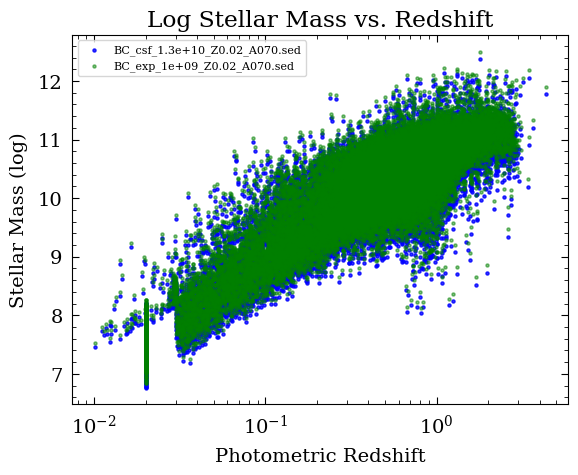

In [26]:
sed_temp_csf = 'BC_csf_1.3e+10_Z0.02_A070.sed'
L_nu_csf, lam_csf, params_csf = get_SED(sed_temp_csf)
sed_temp_exp = 'BC_exp_1e+09_Z0.02_A070.sed'
L_nu_exp, lam_exp, params_exp = get_SED(sed_temp_exp)
rs = []
sm_csf = []
sm_exp = []
def rs_sm_plot():
    for i in tqdm(range(cat_len)):
        masses_csf = []
        masses_exp = []
        z = cat_photoz[i]
        for j in range(len(sx_filt)):
            mag = cat[i][j + 4]
            if(j % 2 == 0 and mag > -99):
                obs_lam = sx_wavelengths[int(j / 2)]
                masses_csf.append(calc_Mstar(L_nu_csf, lam_csf, z, mag, obs_lam))
                masses_exp.append(calc_Mstar(L_nu_exp, lam_exp, z, mag, obs_lam))
        mass_csf = np.mean(masses_csf)
        mass_exp = np.mean(masses_exp)
        rs.append(z)
        sm_csf.append(mass_csf)
        sm_exp.append(mass_exp)
    plt.scatter(rs, sm_csf, s = 5, label = sed_temp_csf, c = 'blue', alpha = 0.8)
    plt.scatter(rs, sm_exp, s = 5, label = sed_temp_exp, c = 'green', alpha = 0.5)
    plt.xlabel('Photometric Redshift')
    plt.xscale('log')
    plt.ylabel('Stellar Mass (log)')
    plt.legend(fontsize = 8)
    plt.title('Log Stellar Mass vs. Redshift')
    plt.show()
rs_sm_plot()

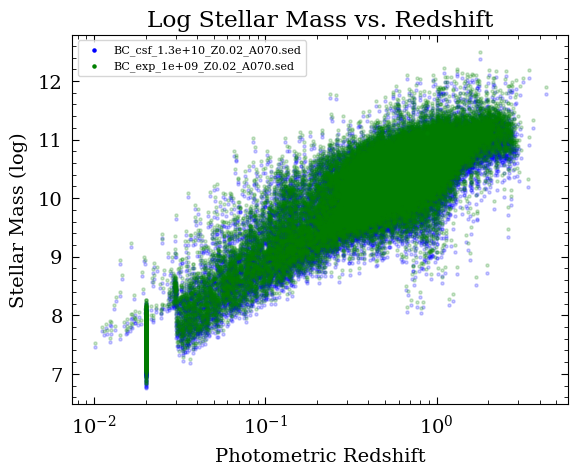

In [27]:
plt.scatter(rs, sm_csf, s = 5, c = 'blue', alpha = 0.2)
plt.scatter(rs, sm_exp, s = 5, c = 'green', alpha = 0.2)
plt.scatter(rs[0], sm_csf[0], s = 5, label = sed_temp_csf, c = 'blue', alpha = 1, zorder = 0)
plt.scatter(rs[0], sm_exp[0], s = 5, label = sed_temp_exp, c = 'green', alpha = 1, zorder = 1)
plt.xlabel('Photometric Redshift')
plt.xscale('log')
plt.ylabel('Stellar Mass (log)')
plt.legend(fontsize = 8)
plt.title('Log Stellar Mass vs. Redshift')
plt.show()

Note that every green point from the exp SED can be found by shifting the corresponding blue point from the csf SED up. For the purposes of our figures from here on, we will only plot the points from the csf SED.

We then store all of the stellar masses into a list, and we add the star formation rate and stellar mass of each object to our catalog. Note that due to some of the objects in our catalog having an indicated redshift of 0, those objects will have an unknown stellar mass and will be marked as -inf. Similarly, unknown values of SFR are denoted with -1.0.

In [30]:
# The indices of the unknown stellar masses
unknown_stellar_mass_inds = []
for i in range(cat_len):
    z = cat_photoz[i]
    if(z == 0):
        unknown_stellar_mass_inds.append(i)
# print(unknown_stellar_mass_inds)

# Set the header for our catalog
pre = ['AKARI_ID', 'HSC_ID', 'HSC_RA', 'HSC_DEC']
# Add sfr and stellar mass to the end of our header
post = ['photoZ', 'cls_quiescent', 'cls_starforming', 
        'cls_type1AGN', 'cls_type2AGN', 'specZ', 
        'LUM_totIR', 'sfr', 'stellar_mass_csf', 'stellar_mass_exp']
c = [pre, sx_filt, post]
ca = []
for l in c:
    ca += l
catalog = [ca]

# Fill the data for the catalog
for i in range(cat_len):
    cata = []
    cata.append(cat_akari_id[i])
    cata.append(cat_id[i])
    cata.append(cat_ra[i])
    cata.append(cat_dec[i])
    for j in range(len(sx_filt)):
        cata.append(cat[sx_filt[j]][i])
    cata.append(cat_photoz[i])
    cata.append(cat_q[i])
    cata.append(cat_sf[i])
    cata.append(cat_t1[i])
    cata.append(cat_t2[i])
    cata.append(cat_specz[i])
    cata.append(cat_lum_ir[i])
    cata.append(sfr[i])
    cata.append(sm_csf[i])
    cata.append(sm_exp[i])
    catalog.append(cata)
# Write the contents of our catalog onto a txt file
f = open('SURF_2023_CATALOG.txt', 'w')
for c in catalog:
    line = ', '.join(str(s) for s in c)
    f.write(line + '\n')
f.close()

In [31]:
# Parse cat_sfr and cat_stellar_mass
cat = Table.read('SURF_2023_CATALOG.txt', format = 'ascii', header_start = 0)
cat_sfr = cat['sfr']
cat_sm_csf = cat['stellar_mass_csf']
cat_sm_exp = cat['stellar_mass_exp']
print(len(cat_sm_csf))

52290


## Star Formation Rate vs. Stellar Mass
Now that we have collected all of the properties for the galaxies in our catalog, we conclude part 1 of the project by plotting some figures, specifically comparing our star formation rates to our stellar masses.

We start by plotting star formation rate vs. stellar mass. We also color code by redshift, as seen by the color bar in the plot. We notice that as redshift increases, there is a general increase in both star formation rate as well as stellar mass.

C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\3884711732.py:1: RuntimeWarning: invalid value encountered in log10
  scatter = plt.scatter(cat_sm_csf, np.log10(cat_sfr), c = cat_photoz, s = 5, alpha = 1, cmap = 'plasma')


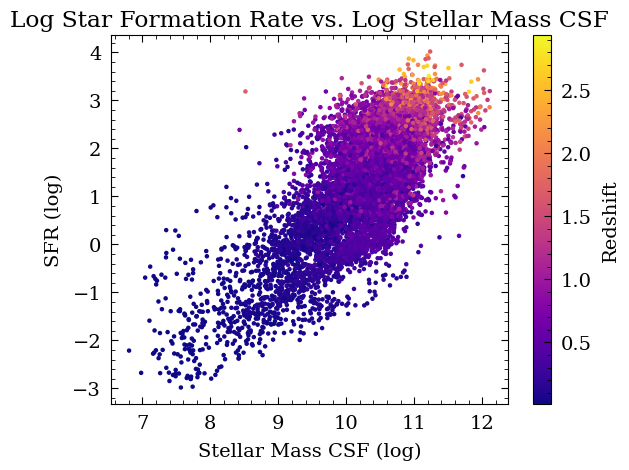

In [32]:
scatter = plt.scatter(cat_sm_csf, np.log10(cat_sfr), c = cat_photoz, s = 5, alpha = 1, cmap = 'plasma')
plt.xlabel('Stellar Mass CSF (log)')
plt.ylabel('SFR (log)')
plt.title('Log Star Formation Rate vs. Log Stellar Mass CSF')
cbar = plt.colorbar(scatter)
cbar.set_label('Redshift')
plt.show()

Now let us create a contour plot of all the objects in the HSC catalog and scatter the objects in our SPHEREx catalog. We first need to collect the sfr's and stellar masses of the objects in the HSC catalog.

In [33]:
hsc_sfr = []
hsc_sm_csf = []
for i in hsc_lum_ir:
    if(i < 0):
        hsc_sfr.append(-1.0)
    else:
        hsc_sfr.append(LIR_to_SFR(i))

sed_temp_csf = 'BC_csf_1.3e+10_Z0.02_A070.sed'
def hsc_sm():
    for i in tqdm(range(hsc_len)):
        hsc_masses_csf = []
        z = hsc_photoz[i]
        for j in range(len(hsc_wavelengths)):
            mag = hsc[i][j * 2 + 4]
            obs_lam = hsc_wavelengths[j]
            if(mag > -99):
                hsc_masses_csf.append(calc_Mstar(L_nu_csf, lam_csf, z, mag, obs_lam))
        hsc_mass_csf = np.mean(hsc_masses_csf)
        hsc_sm_csf.append(hsc_mass_csf)
hsc_sm()

  5%|███▊                                                                         | 3543/70959 [00:38<11:22, 98.71it/s]C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\110165936.py:140: RuntimeWarning: divide by zero encountered in divide
  sed_flux_cgs = L_nu / (4 * np.pi * (DL.value)**2)  # in erg/s/cm2/Hz/Msol
C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\110165936.py:148: RuntimeWarning: divide by zero encountered in log10
  logmstar = np.log10(mstar)
100%|████████████████████████████████████████████████████████████████████████████| 70959/70959 [12:04<00:00, 97.99it/s]


C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\914711895.py:2: RuntimeWarning: invalid value encountered in log10
  y = np.log10(hsc_sfr)
C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\914711895.py:16: RuntimeWarning: invalid value encountered in log10
  scatter = plt.scatter(cat_sm_csf, np.log10(cat_sfr), c = cat_photoz, s = 5, alpha = 0.1, cmap = 'plasma')


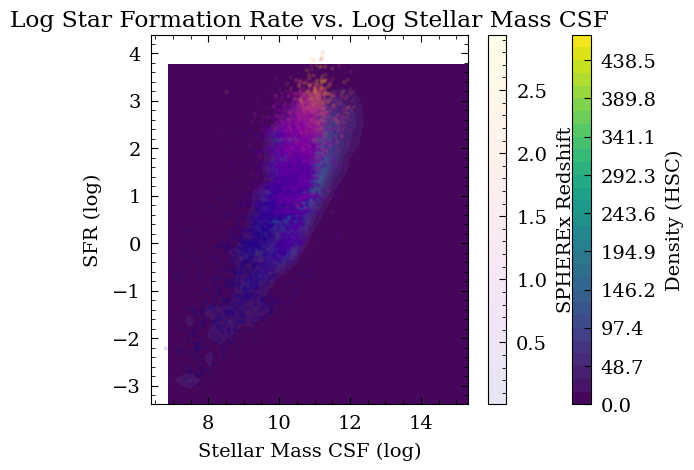

In [34]:
x = hsc_sm_csf
y = np.log10(hsc_sfr)
valid_indices = np.isfinite(x) & np.isfinite(y)
inds = np.where(valid_indices)[0]
x_valid = []
y_valid = []
for i in inds:
    x_valid.append(x[i])
    y_valid.append(y[i])
grid_size = 30
grid, x_edges, y_edges = np.histogram2d(x_valid, y_valid, bins = grid_size)
grid = grid.T
contour_levels = np.linspace(grid.min(), grid.max(), 30)
plt.contourf(x_edges[:-1], y_edges[:-1], grid, levels = contour_levels, cmap = 'viridis')
plt.colorbar(label = 'Density (HSC)')
scatter = plt.scatter(cat_sm_csf, np.log10(cat_sfr), c = cat_photoz, s = 5, alpha = 0.1, cmap = 'plasma')
plt.xlabel('Stellar Mass CSF (log)')
plt.ylabel('SFR (log)')
cbar = plt.colorbar(scatter)
cbar.set_label('SPHEREx Redshift')
plt.title('Log Star Formation Rate vs. Log Stellar Mass CSF')
plt.show()

Finally, we create a contour of both the objects in the HSC catalog as well as the ones in our SPHEREx catalog.

C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\3725595564.py:2: RuntimeWarning: invalid value encountered in log10
  y_hsc = np.log10(hsc_sfr)
C:\Users\edwar\AppData\Local\Temp\ipykernel_25344\3725595564.py:4: RuntimeWarning: invalid value encountered in log10
  y_cat = np.log10(cat_sfr)


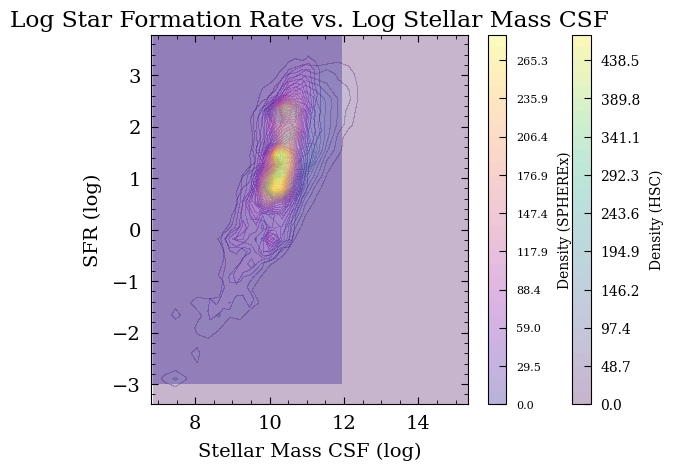

In [35]:
x_hsc = hsc_sm_csf
y_hsc = np.log10(hsc_sfr)
x_cat = cat_sm_csf
y_cat = np.log10(cat_sfr)
valid_indices_hsc = np.isfinite(x_hsc) & np.isfinite(y_hsc)
valid_indices_cat = np.isfinite(x_cat) & np.isfinite(y_cat)
inds_hsc = np.where(valid_indices_hsc)[0]
inds_cat = np.where(valid_indices_cat)[0]
x_valid_hsc = []
y_valid_hsc = []
x_valid_cat = []
y_valid_cat = []
for i in inds_hsc:
    x_valid_hsc.append(x_hsc[i])
    y_valid_hsc.append(y_hsc[i])
for j in inds_cat:
    x_valid_cat.append(x_cat[j])
    y_valid_cat.append(y_cat[j])
grid_size = 30
grid_hsc, x_edges_hsc, y_edges_hsc = np.histogram2d(x_valid_hsc, y_valid_hsc, bins = grid_size)
grid_hsc = grid_hsc.T
grid_cat, x_edges_cat, y_edges_cat = np.histogram2d(x_valid_cat, y_valid_cat, bins = grid_size)
grid_cat = grid_cat.T
contour_levels_hsc = np.linspace(grid_hsc.min(), grid_hsc.max(), 30)
contour_levels_cat = np.linspace(grid_cat.min(), grid_cat.max(), 30)
plt.contourf(x_edges_hsc[:-1], y_edges_hsc[:-1], grid_hsc, levels = contour_levels_hsc, cmap = 'viridis', alpha = 0.3)
cbar_hsc = plt.colorbar()
cbar_hsc.ax.tick_params(labelsize = 10)
cbar_hsc.set_label('Density (HSC)', fontsize = 10)
plt.contourf(x_edges_cat[:-1], y_edges_cat[:-1], grid_cat, levels = contour_levels_cat, cmap = 'plasma', alpha = 0.3)
cbar_cat = plt.colorbar()
cbar_cat.ax.tick_params(labelsize = 8)
cbar_cat.set_label('Density (SPHEREx)', fontsize = 10)
# scatter = plt.scatter(cat_sm_csf, np.log10(cat_sfr), c = cat_photoz, s = 5, alpha = 0.3, cmap = 'plasma')
plt.xlabel('Stellar Mass CSF (log)')
plt.ylabel('SFR (log)')
plt.title('Log Star Formation Rate vs. Log Stellar Mass CSF')
plt.show()

# Part 2
In part 2 of this project, we seek to simulate observed spectra using the SPHEREx Sky Simulator. We begin by normalizing our template SEDs to the objects in our SPHEREx catalog. 

We start by converting the magnitudes of the objects from our SPHEREx catalog into flux in µJy, or erg/s/cm²/Hz. We then plot flux over wavelength for any given object in our SPHEREx catalog.

For now, we begin with the object in our SPHEREx catalog with a redshift closest to 0.2, which is found at index 22306.

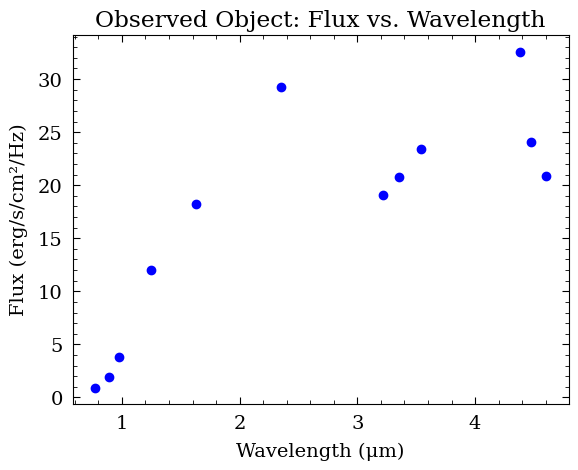

In [36]:
# Given a target value and a list, returns the index of the list with the value closest to the target
def closest_ind(lst, target):
    ind = min(range(len(lst)), key = lambda i: abs(lst[i] - target))
    return ind

# Find index of the object in our SPHEREx catalog with a redshift closest to 0.2
obj_ind = closest_ind(cat_photoz, 0.2)

# Converts AB mag to f_nu (µJy)
def mag_to_f_nu(mag):
    return 10**((float(mag) - 23.9) / -2.5)

# Return ordered lambda and f_nu of one of the observed objects in our SPHEREx catalog
# Also plots f_nu vs. lambda if plt_bool is True
def obs_plot(obs_ind, plt_bool):
    ind = obs_ind + 1
    with open('SURF_2023_CATALOG.txt') as f:
        data = f.readlines()
    info = data[ind].split(', ')
    lam = []
    f_nu = []
    c = 0
    for i in range(30):
        mag_ind = i + 4
        if((mag_ind) % 2 == 0):
            lam.append(sx_wavelengths[c])
            f_nu.append(mag_to_f_nu(info[mag_ind]))
            c += 1
    z = list(zip(lam, f_nu))
    ax = sorted(z, key = lambda x: x[0])
    x = []
    y = []
    for k in range(len(ax)):
        # Filter out unknowns
        # Unknown mag of -99.0 results in f_nu of 1.44543977074594e+49
        if(ax[k][1] <= 1e49):
            x.append(ax[k][0])
            y.append(ax[k][1])
    if(plt_bool):
        plt.scatter(x, y, c = 'blue')
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Flux (erg/s/cm²/Hz)')
        plt.title('Observed Object: Flux vs. Wavelength')
        plt.show()
    return x, y
lam_obs, f_nu_obs = obs_plot(obj_ind, True)

Next, we plot the luminosity in erg/s/Hz/Msol over wavelength for any given template SED.

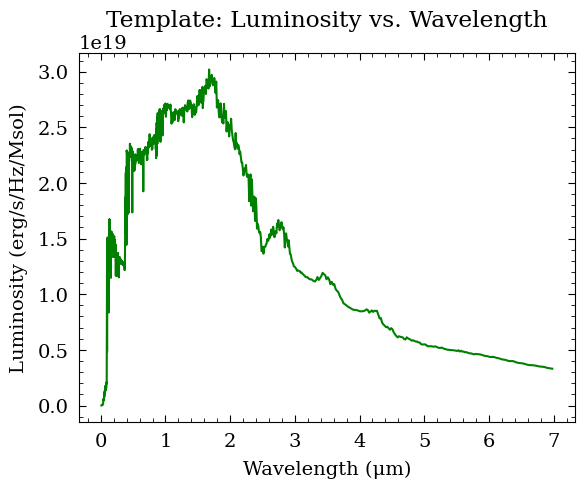

In [37]:
# Define the template SED that we will be using
sed_temp = 'BC_csf_1.3e+10_Z0.02_A070.sed'

# Return ordered lambda and L_nu of one of the template SEDs
# Also plots L_nu vs. lambda if plt_bool is True
def temp_plot(temp, plt_bool, color):
    L_nu, lam, params = get_SED(temp)
    z = list(zip(lam, L_nu))
    ax = sorted(z, key = lambda x: x[0])
    x = []
    y = []
    for k in range(len(ax)):
        # Filter for SphereX sensitivities
        if(ax[k][0] <= 7e4):
            x.append(ax[k][0] * 10**-4)
            y.append(ax[k][1])
    if(plt_bool):
        plt.plot(x, y, c = color)
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Luminosity (erg/s/Hz/Msol)')
        plt.title('Template: Luminosity vs. Wavelength')
        plt.show()
    return x, y
lam_temp, L_nu_temp = temp_plot(sed_temp, True, 'green')

Now, we take a template SED and allow it to account for dust attenuation using the calzetti function.

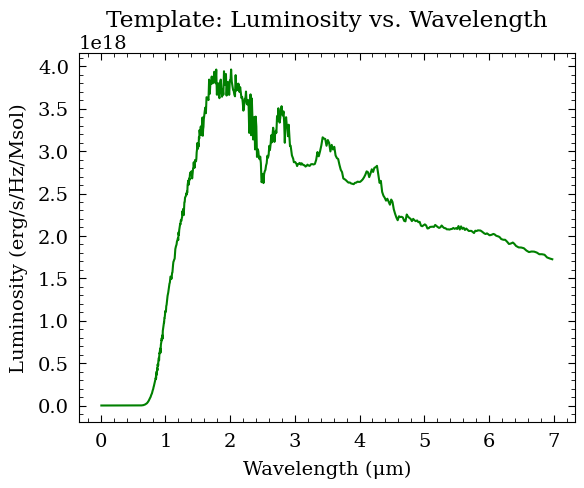

In [38]:
# Calzetti function to allow our flux to account for dust attenuation
def calzetti(lam, ebmv):
    '''
    Returns "klam" and "ext" for Calzetti dust. 
    
    INPUT
    =====
    lam: rest-frame wavelength in A
    ebmv: E(B-V) in mag 
    '''    
    if((type(lam) == float) | (type(lam) == int)):
        lam = np.asarray([lam])
    Rv = 4.05 	#Calzetti 2000
    lammu = []
    for k in lam:
        lammu.append(k / 10000)
    klam = []
    for i in range(len(lam)):
        if(lam[i] < 1200):
            klam.append(2.659 * (-2.156 + 1.509 / lammu[i] - 0.198 / lammu[i]**2 + 0.011 / lammu[i]**3) + Rv)
        elif(lam[i] >= 1200) & (lam[i] < 6300):
            klam.append(2.659 * (-2.156 + 1.509 / lammu[i] - 0.198 / lammu[i]**2 + 0.011 / lammu[i]**3) + Rv)
        else:
            klam.append(2.659 * (-1.857 + 1.040 / lammu[i]) + Rv)
    klam = np.asarray(klam)
    klam[klam < 0] = 0
    ext = 10**(-0.4 * ebmv * klam)
    out = {'klam':klam , 'ext':ext}
    return(out)

# Return ordered lambda and L_nu of one of the template SEDs under calzetti function
# Also plots L_nu vs. lambda if plt_bool is True
def temp_calz_plot(temp, ebmv, plt_bool, color):
    lam_temp, L_nu_temp = temp_plot(temp, False, color)
    # Account for dust attenuation
    lam_temp_calz = []
    for k in lam_temp:
        lam_temp_calz.append(k * 1000)
    calz = calzetti(lam_temp_calz, ebmv)
    L_nu_temp_calz = []    
    for j in range(len(L_nu_temp)):
        L_nu_temp_calz.append(L_nu_temp[j] * calz['ext'][j])
        
    if(plt_bool):
        plt.plot(lam_temp, L_nu_temp_calz, c = color)
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Luminosity (erg/s/Hz/Msol)')
        plt.title('Template: Luminosity vs. Wavelength')
        plt.show()
    return lam_temp, L_nu_temp_calz
lam_temp, L_nu_temp_calz = temp_calz_plot(sed_temp, 0.23, True, 'green')

We then normalize the two by multiplying the normalization factor at a wavelength of 2.2 μm.

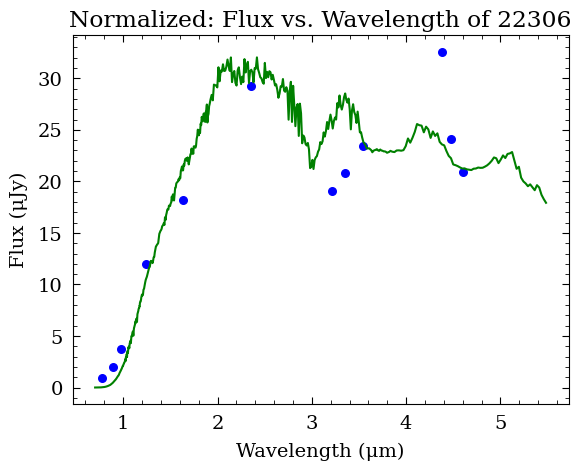

In [39]:
# Normalize given any obs and temp
def norm_obs_temp(obs, temp, ebmv, color):
    lam_obs, f_nu_obs = obs_plot(obs, False)
    lam_temp, L_nu_temp = temp_calz_plot(temp, ebmv, False, color)
    z = cat_photoz[obs]
    
    lam = []
    L_nu = []
    for i in range(len(lam_temp)):
        lam.append(lam_temp[i] * (1 + z))
    obs_ind = closest_ind(lam_obs, 2.2)
    temp_ind = closest_ind(lam, 2.2)
    f = f_nu_obs[obs_ind]
    L = L_nu_temp[temp_ind]
    n = f / L
    for j in range(len(lam)):
        L_nu.append(L_nu_temp[j] * n)
    
    x_temp = []
    y_temp = []
    for k in range(len(lam)):
        # Filter for SphereX sensitivities
        if(lam[k] >= 0.7 and lam[k] <= 5.5):
            x_temp.append(lam[k])
            y_temp.append(L_nu[k])
            
    plt.scatter(lam_obs, f_nu_obs, s = 30, c = 'blue')
    # plt.scatt(lam_obs, f_nu_obs, c = 'blue')
    plt.plot(x_temp, y_temp, c = color)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Flux (μJy)')
    plt.title('Normalized: Flux vs. Wavelength of ' + str(obs))
    plt.show()
    return lam_obs, f_nu_obs, x_temp, y_temp
lam_obs, f_nu_obs, x_temp, y_temp = norm_obs_temp(obj_ind, sed_temp, 0.23, 'green')

Now that we have normalized our template SED to our SPHEREx catalog, we organize the data into a FITS table. We do this by creating a FITS table of wavelengths (in μm, redshifted) and flux (in μJy) for our given template SED as well as for the given object in our SPHEREx catalog.

In [40]:
y_temp_mjy = [y / 1000 for y in y_temp]
f_nu_obs_mjy = [f / 1000 for f in f_nu_obs]

data_temp = {
    'lambda':x_temp,
    'FLUX':y_temp_mjy
}
data_obs = {
    'lambda':lam_obs,
    'FLUX':f_nu_obs_mjy  
}

table_temp = Table(data_temp)
table_temp['lambda'].unit = 'um'
table_temp['FLUX'].unit = 'mJy'

table_obs = Table(data_obs)
table_obs['lambda'].unit = 'um'
table_obs['FLUX'].unit = 'mJy'

temp_file = 'fits_temp_22306.fits'
obs_file = 'fits_obs_22306.fits'
table_temp.write(temp_file, format = 'fits', overwrite = True)
table_obs.write(obs_file, format = 'fits', overwrite = True)

Now let us find a brighter object in our SPHEREx catalog with a redshift still close to 0.2, and we will repeat the process to create the FITS table for this object at index 1038 with redshift 0.2006.

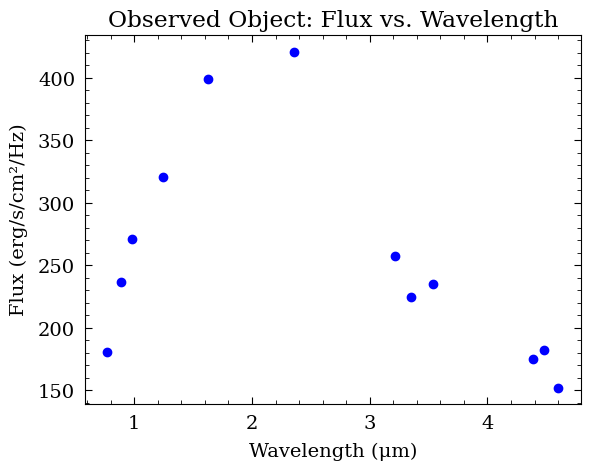

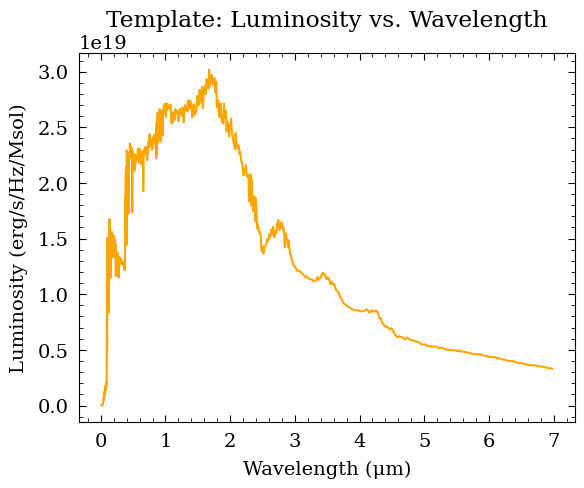

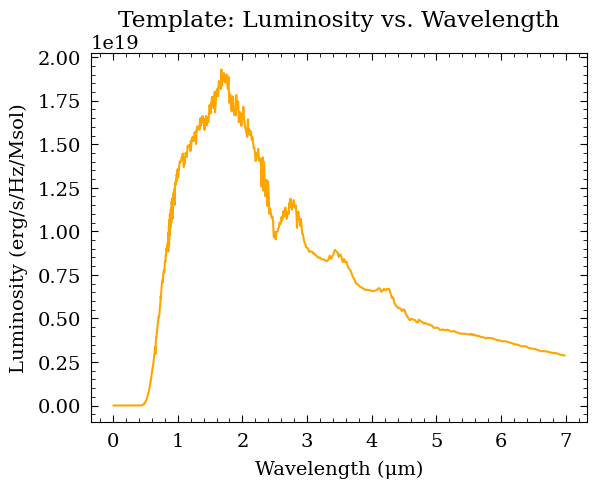

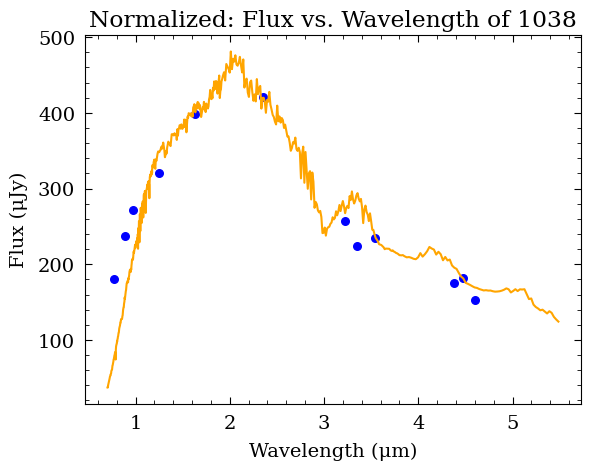

In [41]:
z_02 = np.where((cat_photoz > 0.199) & (cat_photoz < 0.201))
obj_ind = z_02[0][2]
# print(obj_ind)
# print(cat_photoz[obj_ind])

lam_obs, f_nu_obs = obs_plot(obj_ind, True)
lam_temp, L_nu_temp = temp_plot(sed_temp, True, 'orange')
lam_temp, L_nu_temp_calz = temp_calz_plot(sed_temp, 0.05, True, 'orange')
lam_obs, f_nu_obs, x_temp, y_temp = norm_obs_temp(obj_ind, sed_temp, 0.05, 'orange')

In [42]:
y_temp_mjy = [y / 1000 for y in y_temp]
f_nu_obs_mjy = [f / 1000 for f in f_nu_obs]

data_temp = {
    'lambda':x_temp,
    'FLUX':y_temp_mjy
}
data_obs = {
    'lambda':lam_obs,
    'FLUX':f_nu_obs_mjy  
}

table_temp = Table(data_temp)
table_temp['lambda'].unit = 'um'
table_temp['FLUX'].unit = 'mJy'

table_obs = Table(data_obs)
table_obs['lambda'].unit = 'um'
table_obs['FLUX'].unit = 'mJy'

temp_file = 'fits_temp_1038.fits'
obs_file = 'fits_obs_1038.fits'
table_temp.write(temp_file, format = 'fits', overwrite = True)
table_obs.write(obs_file, format = 'fits', overwrite = True)

## Generalize Analysis: For what galaxies are we able to observe the PAH 3.3μm emission?

Since our two objects at index 22306 and 1038 both have an unmeasured total IR luminosity and thus an unmeasured star formation rate, we first find an object that is bright, has a redshift close to 0.2, and has a measured sfr. We then repeat the process for our new object, which was found to be at index 5653.

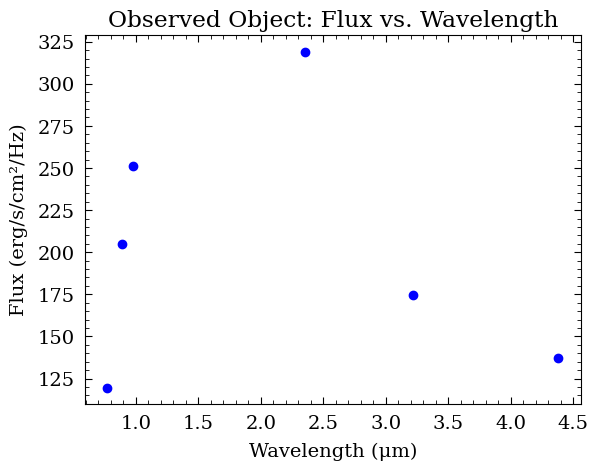

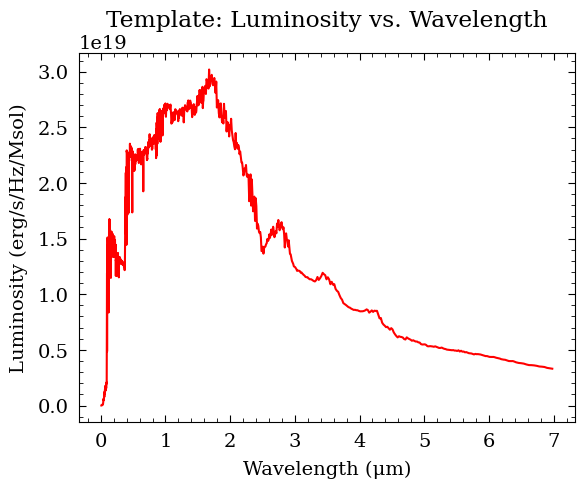

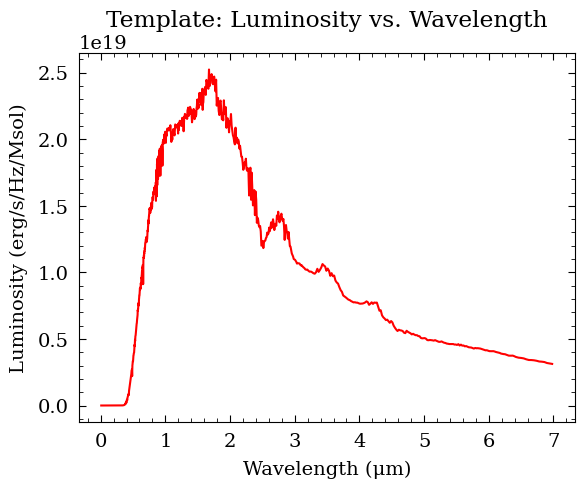

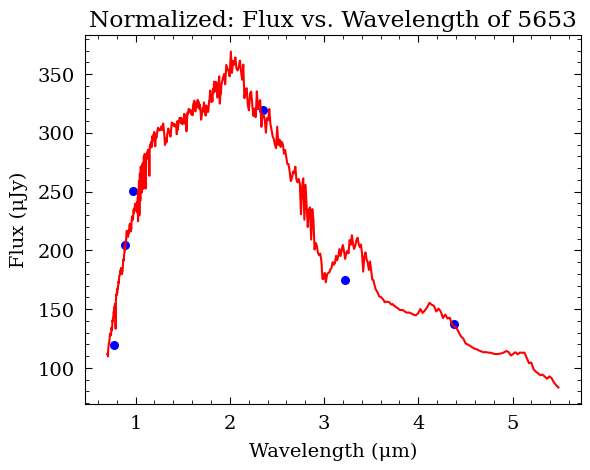

In [43]:
valid_inds = np.where((cat_photoz > 0.199) & (cat_photoz < 0.201) & (cat_sfr > -1.0))
obj_ind = valid_inds[0][1]
# print(obj_ind)
# print(cat_sfr[obj_ind])

lam_obs, f_nu_obs = obs_plot(obj_ind, True)
lam_temp, L_nu_temp = temp_plot(sed_temp, True, 'red')
lam_temp, L_nu_temp_calz = temp_calz_plot(sed_temp, 0.02, True, 'red')
lam_obs, f_nu_obs, x_temp, y_temp = norm_obs_temp(obj_ind, sed_temp, 0.02, 'red')

In [44]:
y_temp_mjy = [y / 1000 for y in y_temp]
f_nu_obs_mjy = [f / 1000 for f in f_nu_obs]

data_temp = {
    'lambda':x_temp,
    'FLUX':y_temp_mjy
}
data_obs = {
    'lambda':lam_obs,
    'FLUX':f_nu_obs_mjy  
}

table_temp = Table(data_temp)
table_temp['lambda'].unit = 'um'
table_temp['FLUX'].unit = 'mJy'

table_obs = Table(data_obs)
table_obs['lambda'].unit = 'um'
table_obs['FLUX'].unit = 'mJy'

temp_file = 'fits_temp_5653.fits'
obs_file = 'fits_obs_5653.fits'
table_temp.write(temp_file, format = 'fits', overwrite = True)
table_obs.write(obs_file, format = 'fits', overwrite = True)

# print(cat_ra[5653])
# print(cat_dec[5653])
print(table_temp)

      lambda               FLUX       
        um                 mJy        
------------------ -------------------
         0.7022925 0.11176543960359375
0.7046935000000001 0.11260524684941708
0.7070945000000001 0.10985036309685278
0.7094955000000001 0.11527210833464648
         0.7118965 0.11687725555744473
0.7142974999999999 0.11821204244138343
0.7166984999999999 0.12084472684942617
0.7190994999999999 0.12088994981365819
0.7215004999999999 0.12169410915699724
0.7239014999999999 0.12476917319154601
               ...                 ...
          5.270195 0.09553549041234818
          5.294205 0.09384452282518593
          5.318215  0.0943274803094333
          5.342225 0.09260074414769312
5.3662350000000005 0.09085843721886906
          5.390245 0.09280209619505762
 5.414254999999999  0.0913488211771512
5.4382649999999995 0.08769015468313138
 5.462274999999999 0.08537886942366435
          5.486285  0.0833839913313397
Length = 557 rows


## Formalize Results

Finally, we will visualize the results of this project. We will do this by creating a plot of star formation rate vs. absolute magnitude at 2.2μm for all of the objects in our SPHEREx catalog, from which we will choose objects from various parts of this plot to generate simulated spectra with the SPHEREx Sky Simulator. We begin by finding the indices of our chosen objects as well as their respective ebmv's. Note that the objects are chosen by their location on the SFR vs. AB mag plot, as well as having a redshift close to 0.2. These values are then used by a function which creates the FITS tables, as well as return the objects' right ascension and declination, to be used by the SPHEREx Sky Simulator.

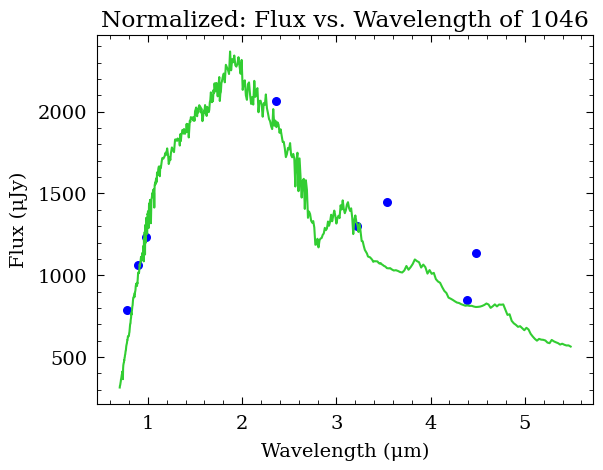

270.82097136096786
67.33984245606662


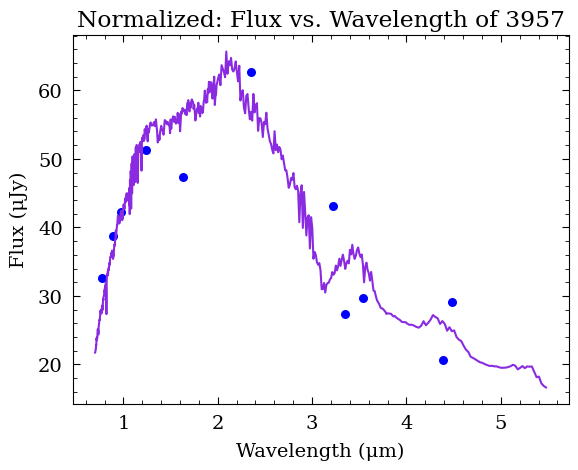

267.3426404461923
66.52463826781306


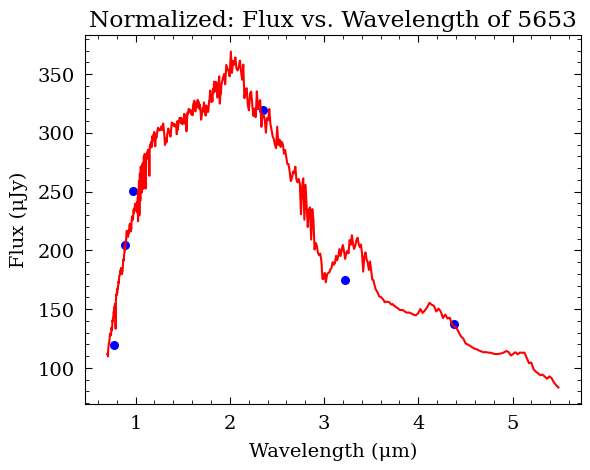

270.6453972716342
66.3478803023114


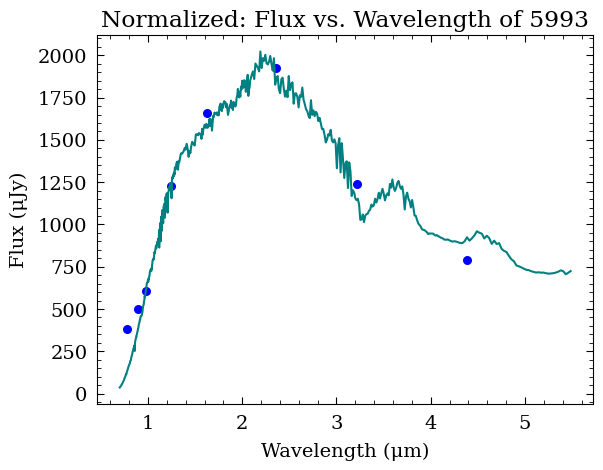

271.8535801455546
66.47874374837086


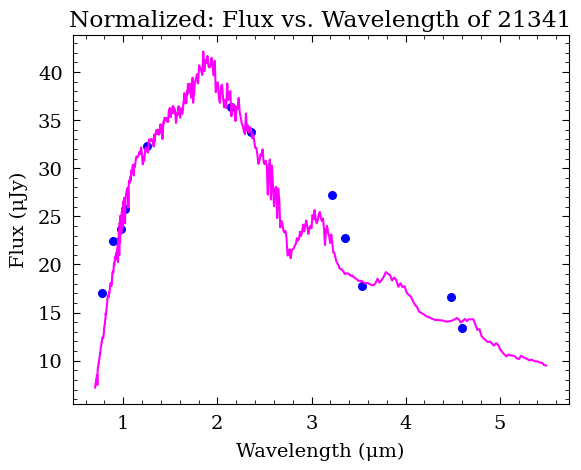

268.8411808005488
66.9128564652515


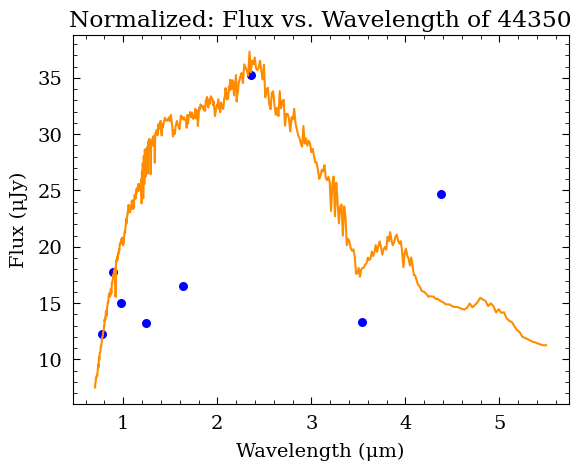

267.31316755392487
66.80093813986156


In [45]:
chosen_inds = [1046, 3957, 5653, 5993, 21341, 44350]
chosen_ebmvs = [0.05, 0.015, 0.02, 0.0575, 0.045, 0.015]
colors = ['limegreen', 'blueviolet', 'red', 'teal', 'magenta', 'darkorange']
def make_fits(obj_ind_list, obj_ebmv_list, color_list):
    for i in range(len(obj_ind_list)):
        obj_ind = obj_ind_list[i]
        obj_ebmv = obj_ebmv_list[i]
        color = colors[i]
        lam_obs, f_nu_obs = obs_plot(obj_ind, False)
        lam_temp, L_nu_temp = temp_plot(sed_temp, False, color)
        lam_temp, L_nu_temp_calz = temp_calz_plot(sed_temp, obj_ebmv, False, color)
        lam_obs, f_nu_obs, x_temp, y_temp = norm_obs_temp(obj_ind, sed_temp, obj_ebmv, color)
        
        y_temp_mjy = [y / 1000 for y in y_temp]
        f_nu_obs_mjy = [f / 1000 for f in f_nu_obs]
        
        data_temp = {
            'lambda':x_temp,
            'FLUX':y_temp_mjy
        }
        data_obs = {
            'lambda':lam_obs,
            'FLUX':f_nu_obs_mjy  
        }
        
        table_temp = Table(data_temp)
        table_temp['lambda'].unit = 'um'
        table_temp['FLUX'].unit = 'mJy'
        
        table_obs = Table(data_obs)
        table_obs['lambda'].unit = 'um'
        table_obs['FLUX'].unit = 'mJy'
        
        temp_file = 'fits_temp_' + str(obj_ind) + '.fits'
        obs_file = 'fits_obs_' + str(obj_ind) + '.fits'
        table_temp.write(temp_file, format = 'fits', overwrite = True)
        table_obs.write(obs_file, format = 'fits', overwrite = True)
        
        print(cat_ra[obj_ind])
        print(cat_dec[obj_ind])

make_fits(chosen_inds, chosen_ebmvs, colors)

We now create the plot of star formation rate vs. absolute magnitude at 2.2μm. We then overlay onto the plot the simulated spectra of our chosen objects in order to easily compare different model spectra in relation to where they lie with regards to their SFR and AB mag. Note that we used two methods of combining our model templates with PAH emissions, one using spectrum 1C and one using the star formation rates of the object. Our simulated spectra for this plot comes from the PAH 3.3um emission based on star formation rate, not the PAH from spectrum 1C. Also note that we omit any objects that have either an unknown SFR or AB mag for the N2m filter (which has a wavelength close to 2.2μm of 2.355041μm). Of the 52290 objects in our SPHEREx catalog, there are 42384 objects omitted, thus we see 9906 objects plotted here.

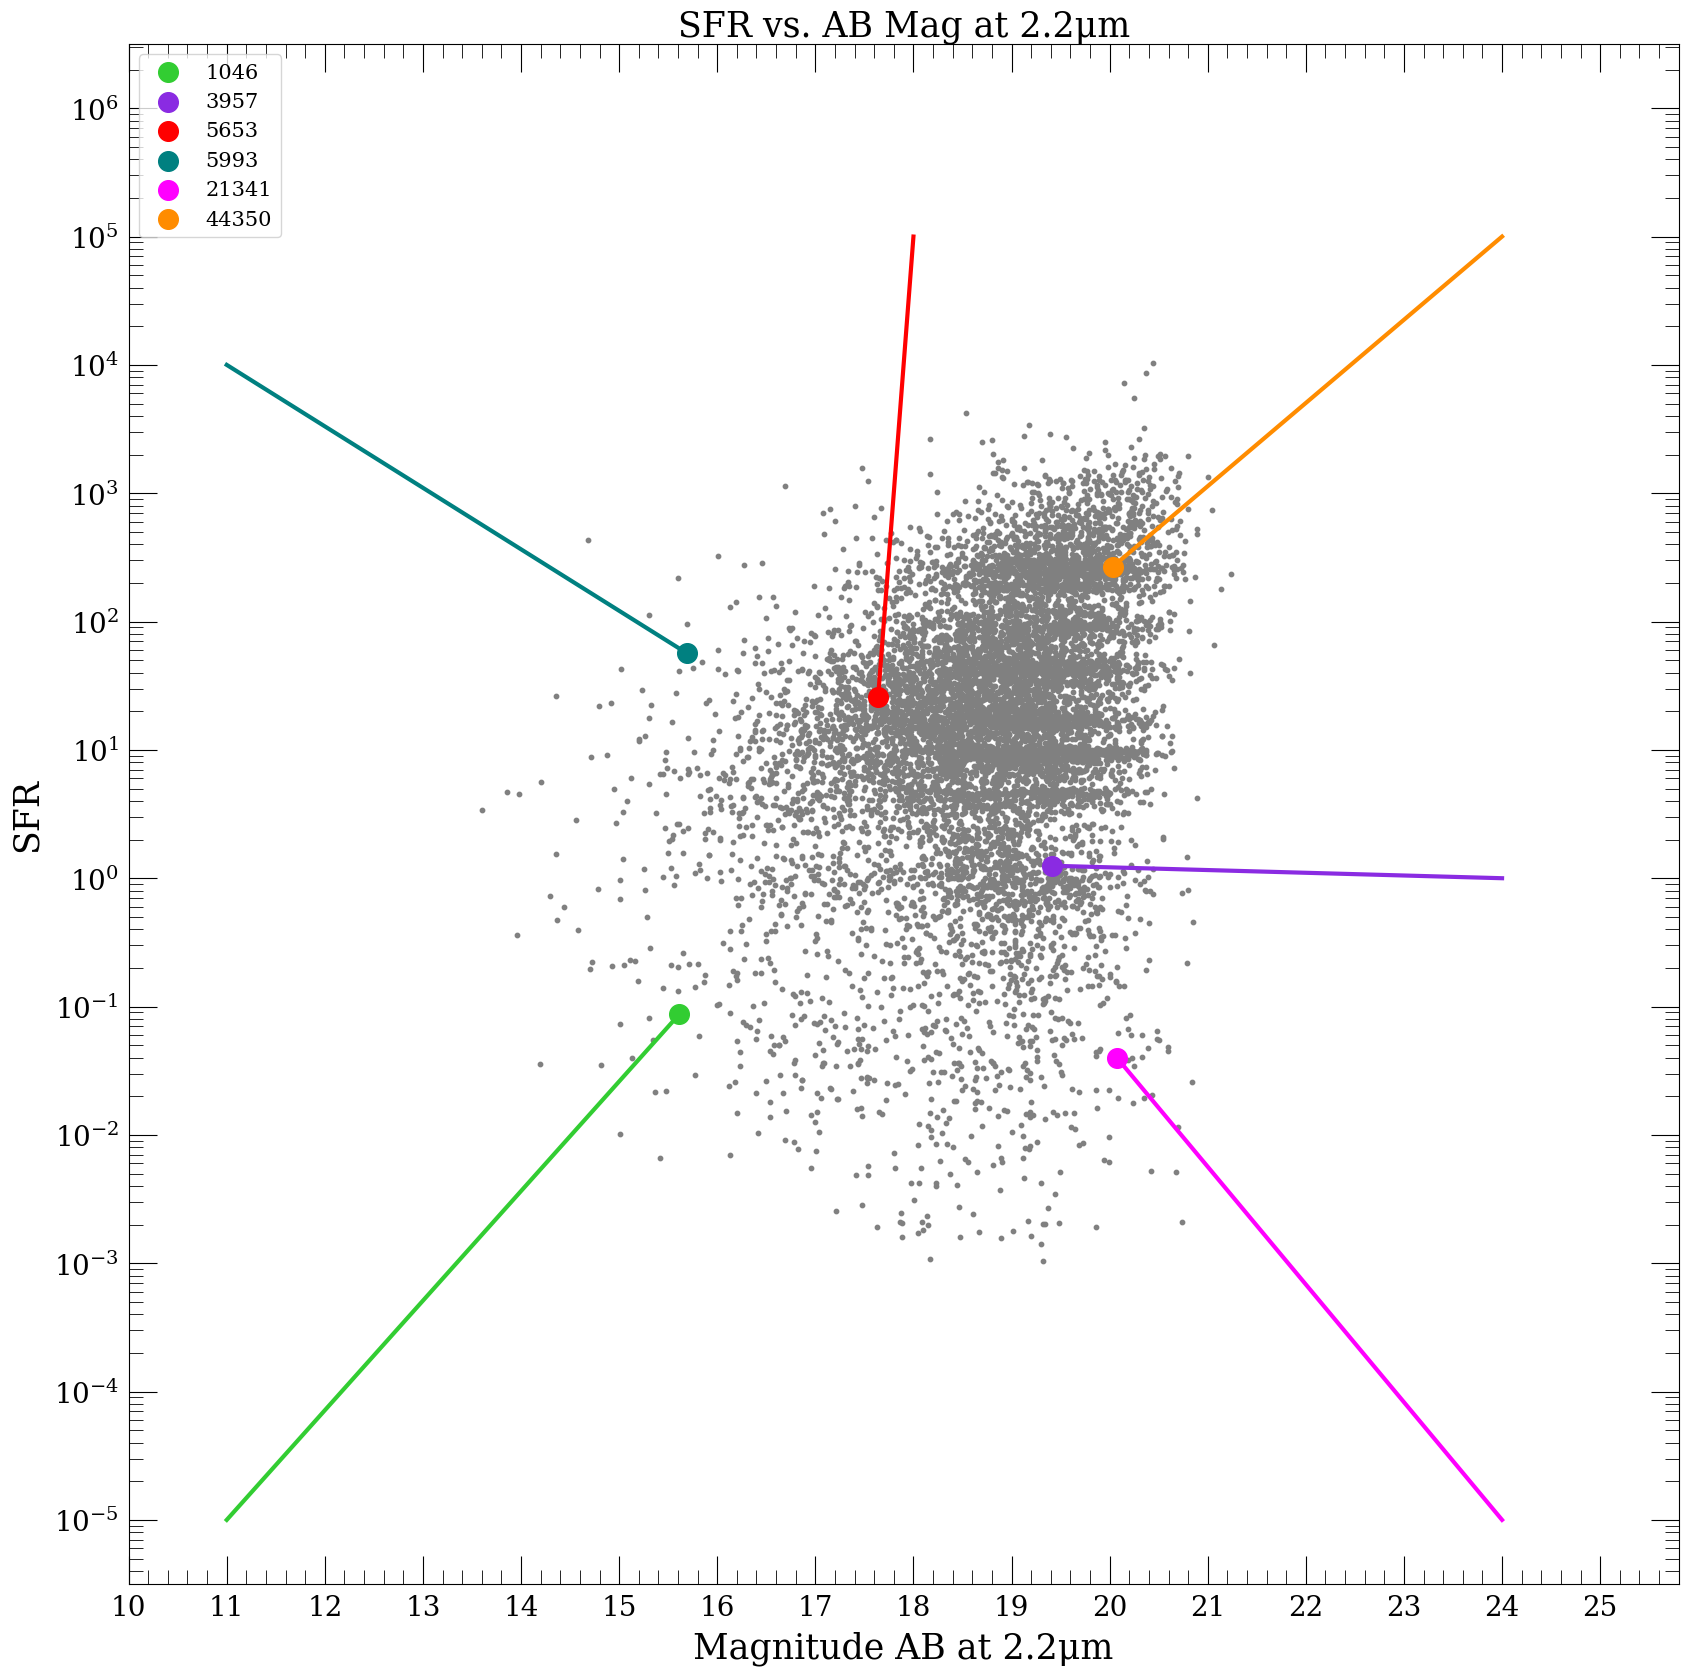

In [46]:
# Define the list of AB magnitudes at the N2m filter wavelength
cat_N2m = cat['N2m']

from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter, FormatStrFormatter
# Plot SFR vs. AB mag
sfr_ab_mag_x = []
sfr_ab_mag_y = []
for i in range(cat_len):
    m = cat_N2m[i]
    s = cat_sfr[i]
    if(m != -99.0 and s != -1.0):
        sfr_ab_mag_x.append(m)
        sfr_ab_mag_y.append(s)

plt.figure(figsize = (20, 20))
plt.scatter(sfr_ab_mag_x, sfr_ab_mag_y, s = 10, c = 'gray')
plt.xlabel('Magnitude AB at 2.2μm', fontsize = 25)
plt.ylabel('SFR', fontsize = 25)
plt.xlim([10, 25])
plt.ylim([10**-5.5, 10**6.5])
plt.title('SFR vs. AB Mag at 2.2μm', fontsize = 25)
# x-axis ticks
major_tick_pos_x = range(10, 26, 1)
plt.xticks(major_tick_pos_x, fontsize = 20)
plt.tick_params(axis = 'x', length = 20)
minor_tick_pos_x = [tick + (i * 0.2) for tick in major_tick_pos_x for i in range(1, 5)]
plt.minorticks_on()
plt.xticks(minor_tick_pos_x, minor = True)
plt.tick_params(axis = 'x', which = 'minor', length = 10)
# y-axis ticks
ax = plt.gca()
ax.set_yscale('log')
locmaj = LogLocator(base = 10, numticks = 999) 
ax.yaxis.set_major_locator(locmaj)
locmin = LogLocator(base = 10.0, subs = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks = 999)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())
ax.tick_params(axis = 'y', length = 20, labelsize = 20)
ax.tick_params(axis = 'y', which = 'minor', length = 10)

# Show the points of the chosen objects
size = 200
plt.scatter(cat_N2m[1046], cat_sfr[1046], s = size, c = 'limegreen', label = '1046')
plt.scatter(cat_N2m[3957], cat_sfr[3957], s = size, c = 'blueviolet', label = '3957')
plt.scatter(cat_N2m[5653], cat_sfr[5653], s = size, c = 'red', label = '5653')
plt.scatter(cat_N2m[5993], cat_sfr[5993], s = size, c = 'teal', label = '5993')
plt.scatter(cat_N2m[21341], cat_sfr[21341], s = size, c = 'magenta', label = '21341')
plt.scatter(cat_N2m[44350], cat_sfr[44350], s = size, c = 'darkorange', label = '44350')
plt.legend(fontsize = 15, loc = 'upper left')

# Make lines connecting the simulated spectra to their respective points
plt.plot([cat_N2m[1046], 11], [cat_sfr[1046], 10e-6], linewidth = 3, c = 'limegreen')
plt.plot([cat_N2m[3957], 24], [cat_sfr[3957], 10e-1], linewidth = 3, c = 'blueviolet')
plt.plot([cat_N2m[5653], 18], [cat_sfr[5653], 10e4], linewidth = 3, c = 'red')
plt.plot([cat_N2m[5993], 11], [cat_sfr[5993], 10e3], linewidth = 3, c = 'teal')
plt.plot([cat_N2m[21341], 24], [cat_sfr[21341], 10e-6], linewidth = 3, c = 'magenta')
plt.plot([cat_N2m[44350], 24], [cat_sfr[44350], 10e4], linewidth = 3, c = 'darkorange')

plt.show()